In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import helperFunctions as hf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from datetime import datetime
import os
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

### Gettign data for speed

In [30]:
def generateTestData(root_folder:str, nimages_per_class= 1500):
    """
    This method takes the root folder of the data and generates a csv file with test data of images.
    If you have number of folders under the root folder having data, evry folder
    must contain "training_data" folder inside. This function goes through all images and samples 
    `2 * nimages_per_class` number of images.
    """
    
    all_images = []
    all_training_norm = pd.DataFrame()
    
    for folder in os.listdir(root_folder):
        data_folder = os.path.join(root_folder,folder)
        if not os.path.isdir(data_folder): continue #if a listed object is not a folder do nothing
        ## read training_norm.csv
        df = pd.read_csv(os.path.join(data_folder,"training_norm.csv"))
        all_training_norm = pd.concat([all_training_norm, df], ignore_index=True)
        ## Images
        images_path = os.path.join(data_folder,"training_data")
        images = os.listdir(images_path)    
        images = [(image.split(".")[0],os.path.join(images_path,image)) for image in images]
        all_images += images
    #Converting list to pandas data frame
    all_images = pd.DataFrame(all_images,columns=["image_id","image_path"])
    print(all_images.dtypes)
    all_images['image_id'] = all_images["image_id"].astype("int64")
    # print(all_images.dtypes)
    # #Join the labels and image paths
    # total_data = pd.merge(all_training_norm,all_images,how="inner",on="image_id")

    # ## Spli the data into classes and sample equal ammount of images
    # df_zero_class = total_data[total_data["speed"]==0.0].sample(n=nimages_per_class,random_state=51)
    # df_1_class = total_data[total_data["speed"]==1.0].sample(n=nimages_per_class,random_state=51)
    # ##Merging them into single data frame again and sufflin them and writing them
    # df_test = pd.concat([df_zero_class,df_1_class],ignore_index=True)
    # df_test = df_test.sample(frac=1)
    # df_test.to_csv(os.path.join(root_folder,"testData.csv"),index=False)
    # print(f"Test data saved successfully to {os.path.join(root_folder,'testData.csv')}")

In [29]:
generateTestData(root_folder="C:\\Users\\GIFT OF GOD\\Desktop\\self_driving_car\\data", nimages_per_class=500)

image_id      object
image_path    object
dtype: object


In [11]:
hf.generateTrainData(root_folder= "C:\\Users\\GIFT OF GOD\\Desktop\\self_driving_car\\data", validation_split=0.15, test_data='/content/data/testData.csv')

('/content/data/trainingData.csv', '/content/data/validationData.csv')

In [10]:
train_ds = hf.getTfDataset(path='C:\\Users\\GIFT OF GOD\\Desktop\\self_driving_car\\data\\trainingData.csv', angle=False, speed=True, img_height=224, img_width= 224)

In [11]:
### Some images
image_batch, speed_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = f"{speed_batch[i]}"
  plt.title(label)
  plt.axis("off")

NotFoundError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: /content/gdrive/MyDrive/autonomous-car/self-driving-car/data/v1/training_data/17756.png : The system cannot find the path specified.
; No such process
	 [[{{node ReadFile}}]] [Op:IteratorGetNext]

In [13]:
### get the validation data

valid_ds = hf.getTfDataset( path='C:\\Users\\GIFT OF GOD\\Desktop\\self_driving_car\\data\\validationData.csv', angle=False, speed=True, img_height=224, img_width= 224)

In [14]:
### Some images
val_image_batch, val_speed_batch = next(iter(valid_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(val_image_batch[i].numpy().astype("uint8"))
  label = f"{val_speed_batch[i]}"
  plt.title(label)
  plt.axis("off")

NotFoundError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: /content/gdrive/MyDrive/autonomous-car/self-driving-car/data/v0/training_data/5353.png : The system cannot find the path specified.
; No such process
	 [[{{node ReadFile}}]] [Op:IteratorGetNext]

## Model

### Speed Model

In [15]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)

# Check data shape after passing it to base_model
#print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
#print(f"After GlobalAveragePooling2D(): {x.shape}")

## Add some dense layers
x = tf.keras.layers.Dense(1024)(x)
tf.keras.layers.Dropout(0.5)
x = tf.keras.layers.Dense(250)(x)
tf.keras.layers.Dropout(0.2)
x = tf.keras.layers.Dense(100)(x)
# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="speed_tl_outputs")(x)

# 8. Combine the inputs with the outputs into a model
model_speed_tl = tf.keras.Model(inputs, outputs)


258076736/258076736 [==============================] - 58s 0us/step


In [16]:
# 9. Compile the model
model_speed_tl.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [17]:
## Early stopping callback
estop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, 
                                                  mode="min",restore_best_weights=True)

In [18]:
## Model checkpoint saving callback
# Include the epoch in the file name (uses `str.format`)
time = datetime.now().strftime("%Y_%m_%d_%I_%m")
checkpoint_path = f"/content/gdrive/MyDrive/autonomous-car/self-driving-car/model_outputs/check_points/training_speed_{time}"+"/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)



# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=0, 
    save_weights_only=True,
    save_freq=5*len(train_ds))


In [19]:
# Freeze all layers except for the block 5
base_model.trainable = False
for layer in base_model.layers[128:]:
    layer.trainable = True

In [20]:

# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block1b_dwconv False
19 block1b_bn False
20 block1b_activation False
21 block1b_se_squeeze False
22 block1b_se_reshape False
23 block1b_se_reduce False
24 block1b_se_expand False
25 block1b_se_excite False
26 block1b_project_conv False
27 block1b_project_bn False
28 block1b_drop False
29 block1b_add False
30 block1c_dwconv False
31 block1c_bn False
32 block1c_activation False
33 block1c_se_squeeze False
34 block1c_se_reshape False
35 block1c_se_reduce False
36 block1c_se_expand False
37 block1c_se_excite False
38 block1c_project_conv False
39 block1c_project_bn False
40

In [21]:
%%time
# 10. Fit the model (we use less steps for validation so it's faster)
history_speed_tl = model_speed_tl.fit(train_ds,validation_data=valid_ds, batch_size=32,
                    epochs=2,verbose=1, callbacks=[estop_callback,cp_callback])

Epoch 1/2


NotFoundError: Graph execution error:

NewRandomAccessFile failed to Create/Open: /content/gdrive/MyDrive/autonomous-car/self-driving-car/data/v1/training_data/17756.png : The system cannot find the path specified.
; No such process
	 [[{{node ReadFile}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_51238]

In [ ]:
## Savign the model
model_speed_tl.save(r'model_outputs\ResnetRS50\saved_model\speed_model')

INFO:tensorflow:Assets written to: model_outputs\ResnetRS50\saved_model\speed_model\assets


INFO:tensorflow:Assets written to: model_outputs\ResnetRS50\saved_model\speed_model\assets


In [ ]:
##Plottign training data

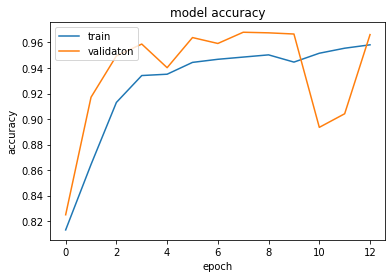

In [ ]:
# summarize history for accuracy
plt.plot(history_speed.history['accuracy'])
plt.plot(history_speed.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validaton'], loc='upper left')


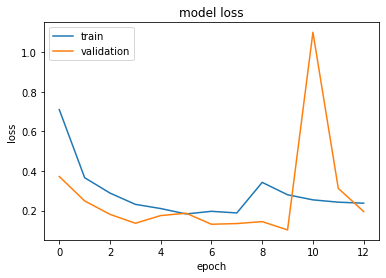

In [ ]:
# summarize history for loss
plt.plot(history_speed.history['loss'])
plt.plot(history_speed.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
valid_ds_for_preds = hf.getTfDataset(r"data\validationData.csv",shuffle=False, 
                                     img_height=224, img_width=224)
validaton_df = pd.read_csv(r"data\validationData.csv")
#predictions = model_speed.predict(valid_ds_for_preds)

In [ ]:
predictions = np.where(predictions>0.5,1,0)
validaton_df = pd.read_csv(r"data\validationData.csv")
validaton_df["predicted_speed"] = predictions
validaton_df.head()

image_id   angle  speed                       image_path  predicted_speed
0      4928  0.5625    1.0   data\v0\training_data\4928.png                1
1     13488  0.6250    1.0  data\v0\training_data\13488.png                1
2      9357  0.4375    1.0   data\v0\training_data\9357.png                1
3      9455  0.3750    1.0   data\v0\training_data\9455.png                1
4      5205  0.5625    1.0   data\v0\training_data\5205.png                1

In [ ]:
accuracy_score(validaton_df["speed"],predictions)

0.9666512274201019

In [ ]:
confusion_matrix(validaton_df["speed"],predictions)

array([[ 325,   53],
       [  19, 1762]], dtype=int64)

In [ ]:
validaton_df[(validaton_df["speed"]==0)&(validaton_df["predicted_speed"]==1)].head(3)

image_id  angle  speed                       image_path  predicted_speed
27      10583  0.625    0.0  data\v0\training_data\10583.png                1
36      10429  0.250    0.0  data\v0\training_data\10429.png                1
122      9054  0.250    0.0   data\v0\training_data\9054.png                1

#### Images correctly classified as stop

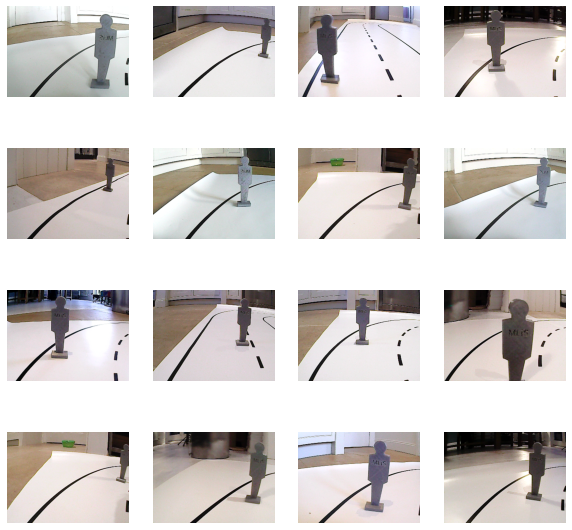

In [ ]:
### Some images
images = validaton_df[(validaton_df["speed"]==0)&(validaton_df["predicted_speed"]==0)]["image_path"].to_list()

plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(mpimg.imread(images[i]))
  #label = f"{val_speed_batch[i]}"
  #plt.title(label)
  plt.axis("off")

#### Images actual stop , predicted go

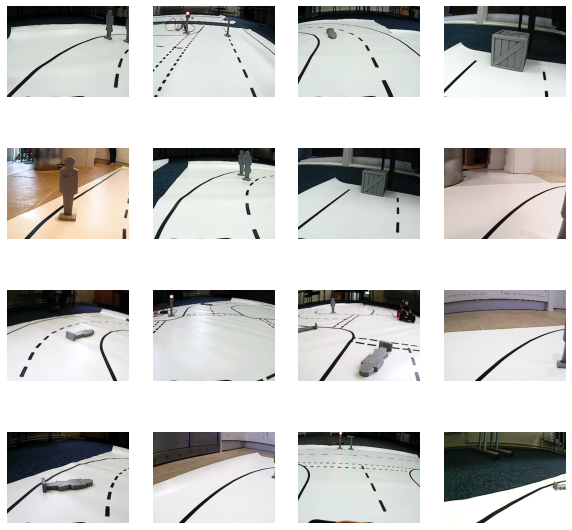

In [ ]:
### Some images
images = validaton_df[(validaton_df["speed"]==0)&(validaton_df["predicted_speed"]==1)]["image_path"].to_list()

plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(mpimg.imread(images[i]))
  #label = f"{val_speed_batch[i]}"
  #plt.title(label)
  plt.axis("off")

#### Images actual go , predicted stop

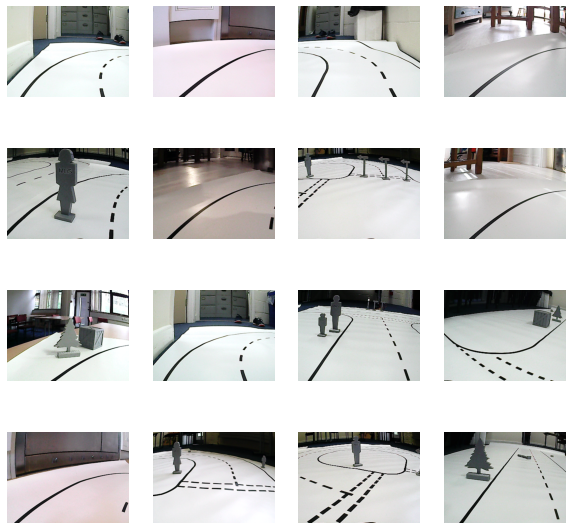

In [ ]:
### Some images
images = validaton_df[(validaton_df["speed"]==1)&(validaton_df["predicted_speed"]==0)]["image_path"].to_list()

plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(mpimg.imread(images[i]))
  #label = f"{val_speed_batch[i]}"
  #plt.title(label)
  plt.axis("off")

### Gettign data for Angle

In [ ]:
train_ds = hf.getTfDataset(angle=True, speed=False, img_height=224, img_width=224)

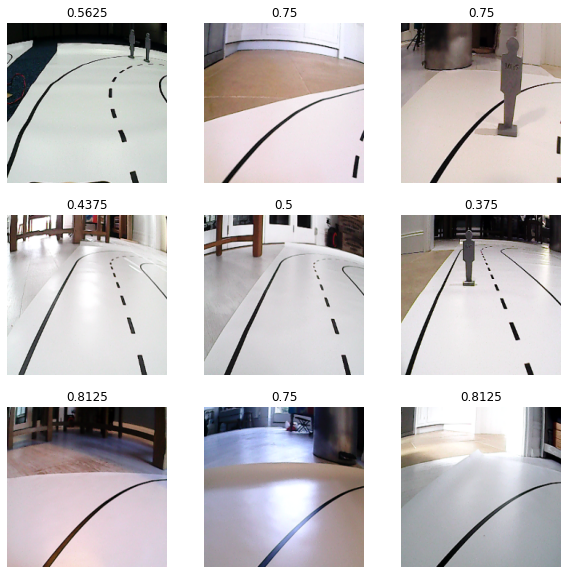

In [ ]:
### Some images
image_batch, angle_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = f"{angle_batch[i]}"
  plt.title(label)
  plt.axis("off")

In [ ]:
### get the validation data

valid_ds = hf.getTfDataset( path='data\\validationData.csv', angle=True, speed=False, img_height=224, img_width=224)

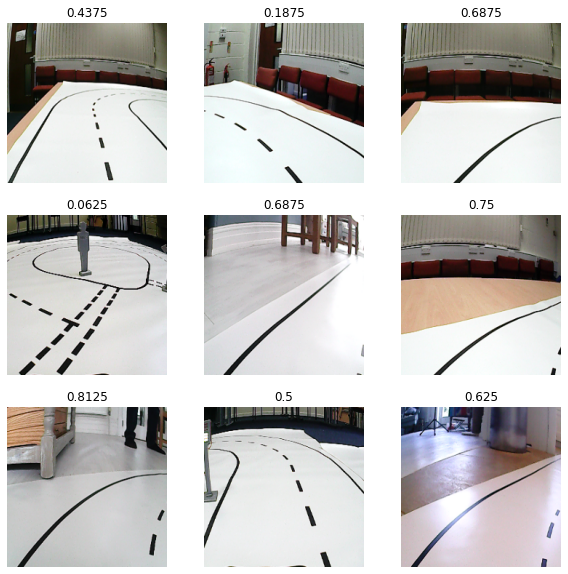

In [ ]:
### Some images
val_image_batch, val_angle_batch = next(iter(valid_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(val_image_batch[i].numpy().astype("uint8"))
  label = f"{val_angle_batch[i]}"
  plt.title(label)
  plt.axis("off")

### Angle Model

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.ResNetRS50(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalMaxPooling2D(name="global_max_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Addign additional dense layer and dropout layer
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# 8. Create the output activation layer
outputs = tf.keras.layers.Dense(1, name="angle_tl_outputs")(x)

# 9. Combine the inputs with the outputs into a model
model_angle_tl = tf.keras.Model(inputs, outputs)


Shape after base_model: (None, 7, 7, 2048)
After GlobalAveragePooling2D(): (None, 2048)


In [ ]:
# 9. Compile the model
model_angle_tl.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanSquaredError()]
)

In [ ]:
## Early stopping callback
estop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, 
                                                  mode="min",restore_best_weights=True)

In [ ]:
## Model checkpoint saving callback
# Include the epoch in the file name (uses `str.format`)
time = datetime.now().strftime("%Y_%m_%d_%I_%m")
checkpoint_path = f"model_outputs\\ResnetRS50\\model_checkpoints\\training_angle_{time}"+"/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)



# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=0, 
    save_weights_only=True,
    save_freq=5*len(train_ds))


In [ ]:
# Freeze all layers except for the block 5
base_model.trainable = False
for layer in base_model.layers[64:]:
    layer.trainable = True

In [ ]:

# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_15 False
1 rescaling_14 False
2 normalization_14 False
3 zero_padding2d_70 False
4 stem_15_stem_conv_1 False
5 stem_15_stem_batch_norm_1 False
6 stem_15_stem_act_1 False
7 stem_15_stem_conv_2 False
8 stem_15_stem_batch_norm_2 False
9 stem_15_stem_act_2 False
10 stem_15_stem_conv_3 False
11 stem_15_stem_batch_norm_3 False
12 stem_15_stem_act_3 False
13 zero_padding2d_71 False
14 stem_15_stem_conv_4 False
15 stem_15_stem_batch_norm_4 False
16 stem_15_stem_act_4 False
17 BlockGroup2__block_0__conv_1 False
18 BlockGroup2__block_0_batch_norm_1 False
19 BlockGroup2__block_0__act_1 False
20 BlockGroup2__block_0__conv_2 False
21 BlockGroup2__block_0__batch_norm_2 False
22 BlockGroup2__block_0__act_2 False
23 BlockGroup2__block_0__conv_3 False
24 BlockGroup2__block_0__batch_norm_3 False
25 BlockGroup2__block_0__se_se_squeeze False
26 BlockGroup2__block_0__se_se_reshape False
27 BlockGroup2__block_0__se_se_reduce False
28 BlockGroup2__block_0__se_se_expand False
29 BlockGroup2__block_0__

In [ ]:
%%time
##Train the model
history_angle = model_angle_tl.fit(train_ds,validation_data=valid_ds, batch_size=32,
                    epochs=20,verbose=1, callbacks=[estop_callback,cp_callback])

Epoch 1/20
270/270 [==============================] - 74s 248ms/step - loss: 77.6597 - mean_squared_error: 77.6597 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 2/20
270/270 [==============================] - 66s 244ms/step - loss: 0.1304 - mean_squared_error: 0.1304 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 3/20
270/270 [==============================] - 65s 242ms/step - loss: 0.0732 - mean_squared_error: 0.0732 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 4/20
270/270 [==============================] - 65s 243ms/step - loss: 0.0508 - mean_squared_error: 0.0508 - val_loss: 0.0146 - val_mean_squared_error: 0.0146
Epoch 5/20
270/270 [==============================] - 67s 250ms/step - loss: 0.0250 - mean_squared_error: 0.0250 - val_loss: 0.0152 - val_mean_squared_error: 0.0152
Wall time: 5min 38s


In [ ]:
## Savign the model
model_angle_tl.save(r'model_outputs\ResnetRS50\saved_model\angle_model')

INFO:tensorflow:Assets written to: model_outputs\ResnetRS50\saved_model\angle_model\assets


INFO:tensorflow:Assets written to: model_outputs\ResnetRS50\saved_model\angle_model\assets


In [ ]:
##Plottign training data

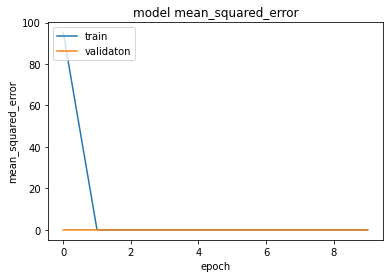

In [ ]:
# summarize history for accuracy
plt.plot(history_angle.history['mean_squared_error'])
plt.plot(history_angle.history['val_mean_squared_error'])
plt.title('model mean_squared_error')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'validaton'], loc='upper left')
plt.show()

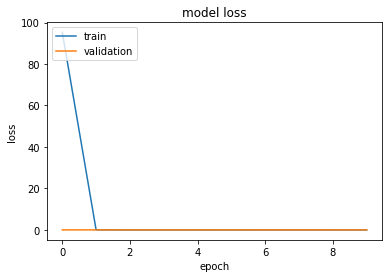

In [ ]:
# summarize history for loss
plt.plot(history_angle.history['loss'])
plt.plot(history_angle.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
angle_preds = model_angle.predict(valid_ds_for_preds)

68/68 [==============================] - 5s 71ms/step


In [ ]:
validaton_df = pd.read_csv(r"data\validationData.csv")
validaton_df["predicted_angle"] = angle_preds
validaton_df["diff%"] = abs(validaton_df["angle"] - validaton_df["predicted_angle"])/(validaton_df["angle"]+10**-8) * 100
validaton_df.head()


image_id   angle  speed                       image_path  predicted_angle  \
0      4928  0.5625    1.0   data\v0\training_data\4928.png         0.487325   
1     13488  0.6250    1.0  data\v0\training_data\13488.png         0.562795   
2      9357  0.4375    1.0   data\v0\training_data\9357.png         0.520378   
3      9455  0.3750    1.0   data\v0\training_data\9455.png         0.262067   
4      5205  0.5625    1.0   data\v0\training_data\5205.png         0.626491   

       diff%  
0  13.364378  
1   9.952764  
2  18.943650  
3  30.115524  
4  11.376190

In [ ]:
validaton_df["diff%"].describe()

count    2.159000e+03
mean     7.781003e+06
std      1.284424e+08
min      5.693436e-03
25%      3.804376e+00
50%      7.851372e+00
75%      1.378923e+01
max      3.108009e+09
Name: diff%, dtype: float64

In [ ]:
validaton_df[validaton_df["diff%"]==float("inf")]

image_id  angle  speed                       image_path  \
214      11731    0.0    1.0  data\v0\training_data\11731.png   
260       3794    0.0    1.0   data\v0\training_data\3794.png   
495        780    0.0    1.0    data\v0\training_data\780.png   
629      12049    0.0    1.0  data\v0\training_data\12049.png   
886       2926    0.0    1.0   data\v0\training_data\2926.png   
1125      7231    0.0    1.0   data\v0\training_data\7231.png   
1169      5403    0.0    1.0   data\v0\training_data\5403.png   
1517     13200    0.0    1.0  data\v0\training_data\13200.png   
2109      2557    0.0    1.0   data\v0\training_data\2557.png   

      predicted_angle  diff%  
214          0.349339    inf  
260          0.283205    inf  
495          0.172477    inf  
629          0.207177    inf  
886          0.239627    inf  
1125         0.152244    inf  
1169         0.157546    inf  
1517         0.167148    inf  
2109         0.203121    inf

## Steering angle error > 75%

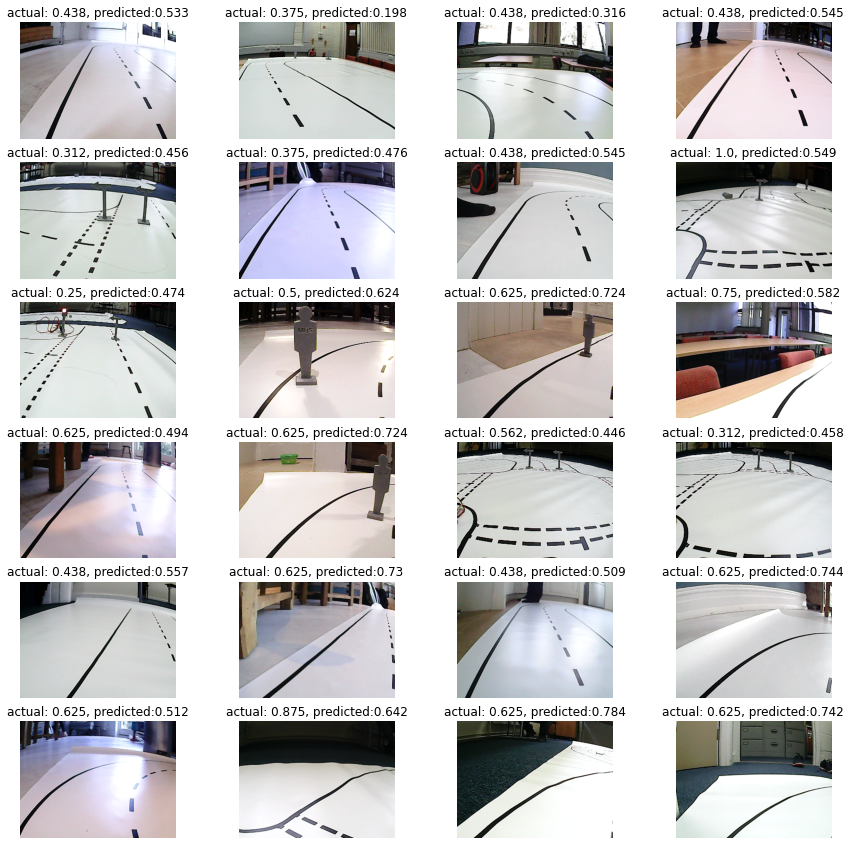

In [ ]:
images = validaton_df[validaton_df["diff%"]>15]["image_path"].to_list()
actual = validaton_df[validaton_df["diff%"]>15]["angle"].to_list()
predicted = validaton_df[validaton_df["diff%"]>15]["predicted_angle"].to_list()

plt.figure(figsize=(15, 15))
for i in range(24):
  ax = plt.subplot(6, 4, i + 1)
  plt.imshow(mpimg.imread(images[i]))
  label = f"actual: {round(actual[i],3)}, predicted:{round(predicted[i],3)}"
  plt.title(label)
  plt.axis("off")

## Steering angle error < 25%

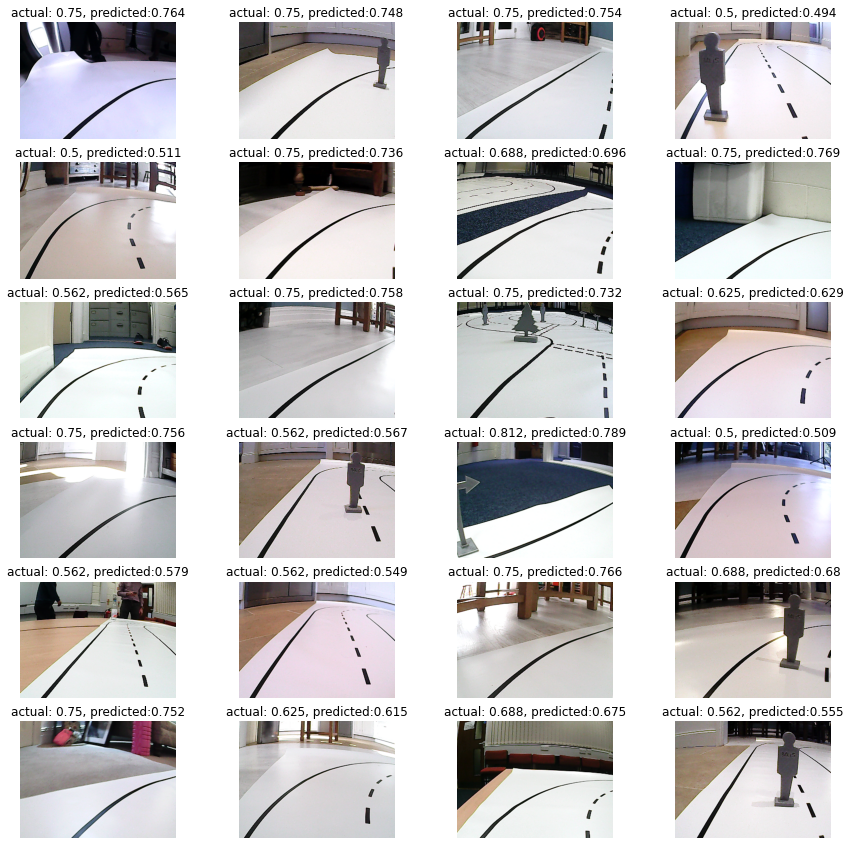

In [ ]:
images = validaton_df[validaton_df["diff%"]<3]["image_path"].to_list()
actual = validaton_df[validaton_df["diff%"]<3]["angle"].to_list()
predicted = validaton_df[validaton_df["diff%"]<3]["predicted_angle"].to_list()

plt.figure(figsize=(15, 15))
for i in range(24):
  ax = plt.subplot(6, 4, i + 1)
  plt.imshow(mpimg.imread(images[i]))
  label = f"actual: {round(actual[i],3)}, predicted:{round(predicted[i],3)}"
  plt.title(label)
  plt.axis("off")

## merging the models

In [ ]:
inputs = keras.Input(shape=(224 , 224, 3), name="img")
angle_output = model_angle_tl(inputs)
speed_output = model_speed_tl(inputs)
model = keras.Model(inputs,outputs=[angle_output,speed_output])
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_13 (Functional)          (None, 1)            34262049    ['img[0][0]']                    
                                                                                                  
 model_2 (Functional)           (None, 1)            33698337    ['img[0][0]']                    
                                                                                                  
Total params: 67,960,386
Trainable params: 567,810
Non-trainable params: 67,392,576
_______

In [ ]:
### savign the model
model.save(r'model_outputs\ResnetRS50\saved_model\combinedModel')

INFO:tensorflow:Assets written to: model_outputs\toy_resnet\saved_model\combinedModel\assets


INFO:tensorflow:Assets written to: model_outputs\toy_resnet\saved_model\combinedModel\assets


In [ ]:
preds_combine = model.predict(valid_ds_for_preds)

68/68 [==============================] - 18s 219ms/step


In [ ]:
##Old One
speed_preds = np.where(preds_combine[1]>0.5,1,0)
accuracy_score(validaton_df["speed"],speed_preds)

0.9666512274201019

In [ ]:
speed_preds = np.where(preds_combine[1]>0.5,1,0)
accuracy_score(validaton_df["speed"],speed_preds)

0.9652616952292729

In [ ]:
preds_combine[1]

array([[1.        ],
       [1.        ],
       [0.999742  ],
       ...,
       [0.9990707 ],
       [0.9198503 ],
       [0.97436935]], dtype=float32)

In [ ]:
##Old one
angle_preds = preds_combine[0]
mean_squared_error(validaton_df["angle"],angle_preds)

0.006352738617420139

In [ ]:
angle_preds = preds_combine[0]
mean_squared_error(validaton_df["angle"],angle_preds)

0.04450663943905416